<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/FastAI_PETS_SimilarCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [1]:
!pip install -Uqq fastai

import fastai
fastai.__version__

PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_similarcats_001.pkl"

## **PETS Dataset**

Load the PETS dataset:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))


There are 7390 images


In [3]:
#create a directory for this challenge and build folders for each breed
dest = os.path.join(path, "challenge")
if not os.path.exists(dest):
  os.path.makedirs(dest)

ftypes = ("Ragdoll*", "Birman*")
import glob
for ftype in ftypes:
  for fname in glob.glob(r"%s/images/%s"%(path, ftype)):
    shutil.copy(fname, dest)
    

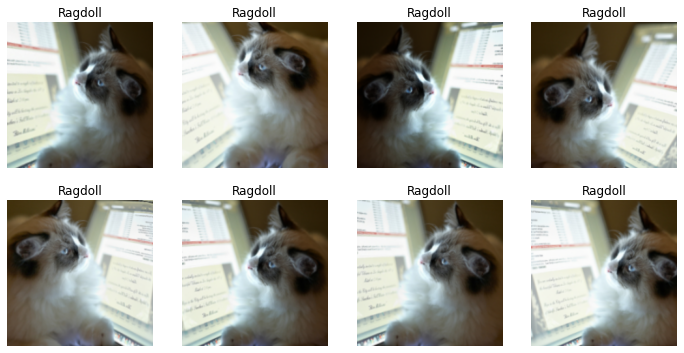

In [4]:
# Label is parsed from file name
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"challenge")
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## **Build a Simple Model**

In [38]:
# Train Model with RESNET34
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.034176,0.490702,0.162500,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.357320,0.699978,0.175000,00:03


**That's a terrble error rate: 17.5%!!!!**

Lets look at the confusion matrix and top losses:

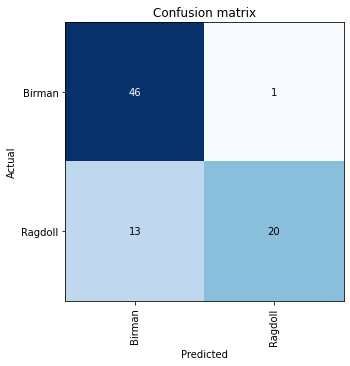

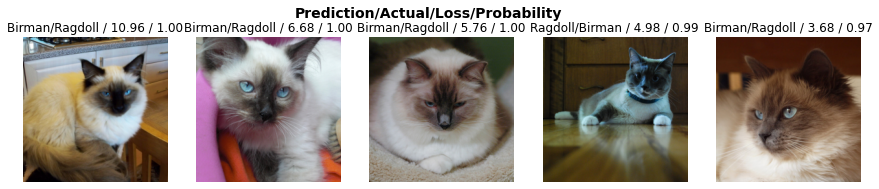

In [43]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.most_confused(min_val=5)
interp.plot_top_losses(5, nrows=1)

## **Let's build a better Model**

Things to try:
- Add data augmentation to input images
- Try a different base model (RESNET101, AlexNet, etc)
- Tune the learning rate***
- Go Deeper***

*** These steps didn't improve things...but did help when training againts all 37 breeds in [FastAI_PETS_Learning_Rate.ipynb](https://colab.research.google.com/drive/1qtc2k894bBKcDfo9OAOYapjioCKC4Qb5#scrollTo=BTiPUt268c3V)

## **1) Data Augmentation**
- Apply batch transforms (scaling, etc)
(More things to try in [FastAI_PETS_Playground.ipynb](https://colab.research.google.com/drive/1Is0qBT2HqrE4t8rY2PZ9kZhUCzHBH9NF) that I haven't explored yet)

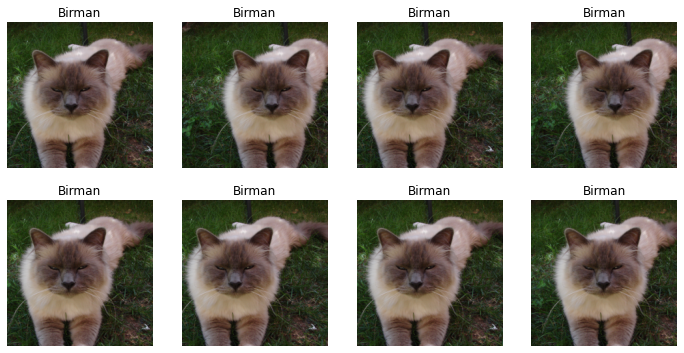

In [23]:
# Only Resize Operation Applied to data
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=1),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 )
dls = pets.dataloaders(dest)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

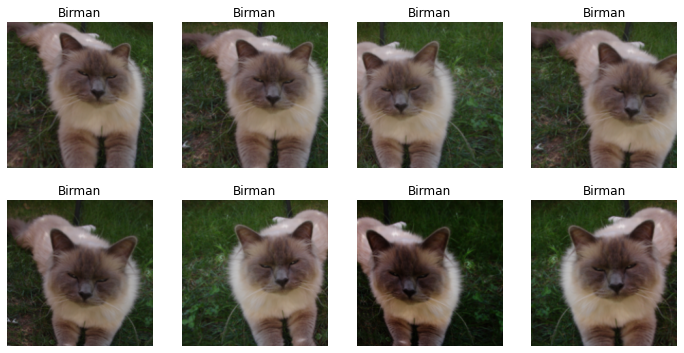

In [40]:
# Batch Transform
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=1),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(dest)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [25]:
# Let's build a model w/ new dataset
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.038198,0.334276,0.150000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.468280,0.355136,0.137500,00:03


**Error Rate droped to 12.5% from 17.5%!!!**

## **2) Let's try a new base model**
The bigger models require more layers to be beneficial, let's run 5 epochs

**Summary:** 
- RESENT looks like the best model, but there are so many knobs that can be tweaked
- RESNET101 gave best performance w/ 7.5% error rate

In [8]:
# RESNET34
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.103881,0.629456,0.275000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.540573,0.384044,0.150000,00:03
1,0.435017,0.394987,0.137500,00:03
2,0.354131,0.394224,0.112500,00:03
3,0.285222,0.384181,0.125000,00:03
4,0.243785,0.384832,0.125000,00:03


In [7]:
# RESNET101
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.978418,0.388922,0.125000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.531475,0.833775,0.200000,00:08
1,0.432467,0.412122,0.175000,00:07
2,0.356432,0.557871,0.175000,00:07
3,0.294604,0.286734,0.075000,00:07
4,0.237914,0.299131,0.075000,00:07


In [9]:
# RESNET152
# - to_fp16() uses half precision floats...resnet152 with full floats ran out of CUDA memory...oops
learn = cnn_learner(dls, resnet152, metrics=error_rate).to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.993515,0.470088,0.225000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.480642,1.237267,0.225000,00:06
1,0.411656,0.797268,0.137500,00:06
2,0.317929,0.557043,0.137500,00:06
3,0.257256,0.478950,0.100000,00:06
4,0.214484,0.494608,0.100000,00:06


**NOTE: TRAIN_LOSS continues to decrease, but VALID_LOSS is starting to increase which means over fitting**

In [10]:
# ALEXNET
learn = cnn_learner(dls, alexnet, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.003272,1.125495,0.487500,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.775297,0.792301,0.375000,00:02
1,0.741774,0.715735,0.262500,00:02
2,0.646220,0.588561,0.225000,00:02
3,0.572142,0.510529,0.175000,00:02
4,0.517421,0.498294,0.175000,00:02


In [11]:
# VGG19
learn = cnn_learner(dls, vgg19_bn, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.184971,0.454905,0.237500,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.700708,0.397408,0.200000,00:10
1,0.568283,0.322994,0.175000,00:08
2,0.445125,0.329700,0.125000,00:08
3,0.360542,0.339800,0.137500,00:08
4,0.311212,0.344805,0.137500,00:08


## **3) Tune Learning Rate**
For simplicity I'm going to focus on Resnet101, but would like to explore Resnet152 w/ deeper layers

Default learning rate is 2e-3 for fine_tune()

Minimum/10: 1.20e-02, steepest point: 1.00e-03


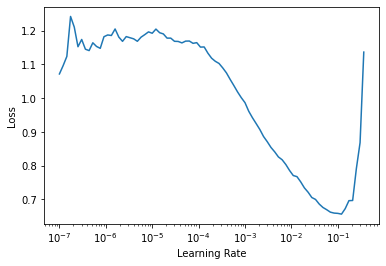

In [37]:
# Find an optimal learning rate
learn = cnn_learner(dls, resnet34, metrics=error_rate)

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [38]:
# Let's try the Min point
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, base_lr=1.2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.845147,1.824504,0.237500,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.642510,0.803459,0.137500,00:03
1,0.612077,1.761162,0.150000,00:03
2,0.470735,1.193708,0.125000,00:03
3,0.381735,0.962517,0.137500,00:03
4,0.314196,0.707685,0.137500,00:03


In [42]:
# Let's try the steepest point
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.182485,0.640174,0.287500,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.580785,0.374951,0.162500,00:03
1,0.540018,0.298692,0.125000,00:03
2,0.505983,0.295902,0.112500,00:03
3,0.439586,0.277652,0.100000,00:03
4,0.380031,0.284755,0.100000,00:03


## **4) Go Deeper**
Let's expirement w/ deeper layers

Minimum/10: 1.20e-02, steepest point: 2.09e-03


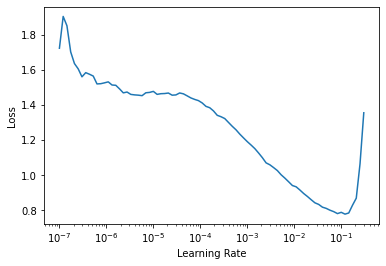

In [43]:
# Lets try steepest
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,time
0,1.163021,0.515791,0.200000,00:03
1,0.807028,0.585423,0.150000,00:03
2,0.658522,0.504937,0.137500,00:03


Minimum/10: 1.20e-04, steepest point: 9.12e-07


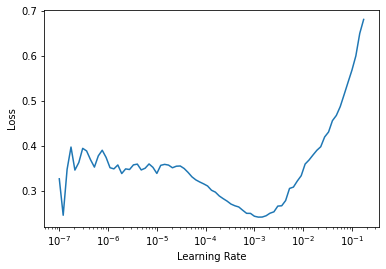

In [44]:
learn.fit_one_cycle(3, lr_max=2.0e-3)

learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [45]:
learn.fit_one_cycle(12, lr_max=slice(5e-5, 1.2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.307966,0.468056,0.137500,00:03
1,0.322650,0.476993,0.150000,00:03
2,0.271699,0.503772,0.150000,00:03
3,0.237429,0.529212,0.150000,00:03
4,0.211171,0.421216,0.137500,00:03
5,0.182682,0.368181,0.125000,00:03
6,0.154793,0.372178,0.112500,00:03
7,0.136608,0.380568,0.112500,00:03
8,0.123519,0.393645,0.100000,00:03
9,0.110550,0.398627,0.100000,00:03


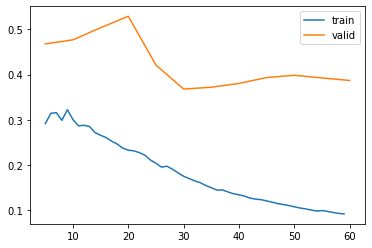

In [46]:
# Lets Plot Loss
learn.recorder.plot_loss()

## **What's Going On?**

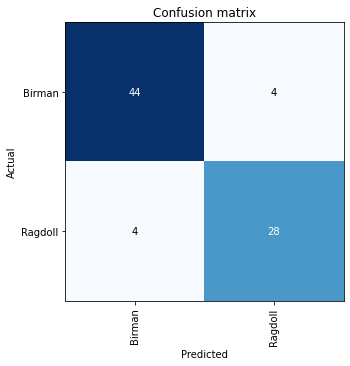

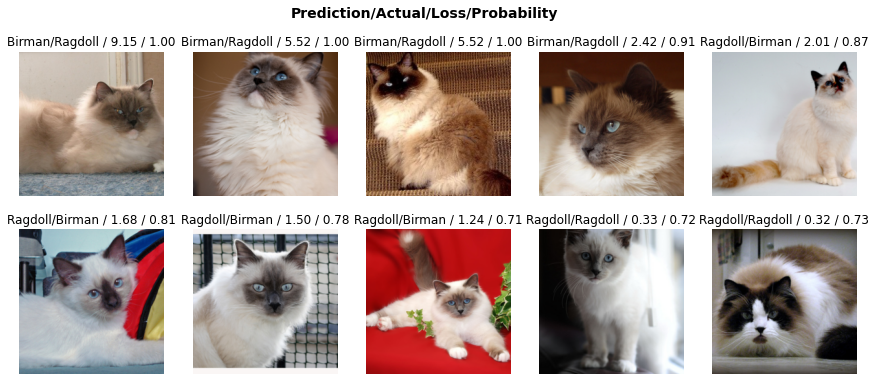

In [48]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.most_confused(min_val=5)
interp.plot_top_losses(10, nrows=2)

**Class Activation Map (CAM) (FastAI 18_CAM.ipynb)**

Useful article: 
https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/visualization/2020/08/27/image-attribution-for-galaxies.html

In [2]:
losses,idxs = interp.top_losses(1)
testFile = None
for idx in idxs:
  testFile = dls.valid_ds.items[idx]

print(testFile)

NameError: ignored

In [55]:
# For CAM we want to store the activations of the last convolutional layer. 
# We put our hook function in a class so it has a state that we can 
# access later, and just store a copy of the output:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)



In [ ]:
with torch.no_grad(): output = learn.model.eval()(x)

act = hook_output.stored[0]

F.softmax(output, dim=-1)